#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [2]:
import sys

sys.path.append(
    "../../ex02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [3]:
import grid_search  # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [5]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # ***************************************************
    # returns mse, and optimal weights
    # ***************************************************
    
    # BAD -- accurracy issue due to inversion
    # optimal_weights = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    
    optimal_weights = np.linalg.solve(tx.T @ tx, tx.T @ y)
    mse = compute_loss(y, tx, optimal_weights)

    
    return optimal_weights, mse

### You can test your implementation here

In [6]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:)

❌ The are some issues with your implementation of `least_squares`:
**********************************************************************
File "__main__", line 13, in least_squares
Failed example:
    least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
Expected:
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
Got:
    (array([ 0.21212121, -0.12121212]), 2.946672814912471e-32)
**********************************************************************


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [7]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    # ***************************************************
    w_ls, loss_ls = least_squares(y, tx)
    grid_losses = gs.grid_search(y, tx, w0, w1)
    loss_star, w0_star, w1_star = gs.get_best_parameters(w0, w1, grid_losses)
    print("lease square: \n\t", "loss: ", loss_ls, "\tweights: ", w_ls)
    print("grid search: \n\t", "loss: ", loss_star, "\tweights: ", np.array([w0_star, w1_star]))

Test it here

In [8]:
test_your_least_squares()

lease square: 
	 loss:  15.385887868829402 	weights:  [73.293922   13.47971243]
grid search: 
	 loss:  377.54061265390845 	weights:  [50.  0.]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [9]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [10]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    # ***************************************************
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    ans = np.ones(x.shape[0]).reshape(x.shape[0], 1)
    for i in range(degree):
        column_i = (x ** (i+1)).reshape(x.shape[0], 1)
        ans = np.append(ans, column_i, axis=1)
    return ans

In [11]:
build_poly(np.array([1, 2, 3]), 3)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

In [12]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [13]:
from plots import *
import build_polynomial as bp

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # form the data to do polynomial regression
        # ***************************************************
        new_x = bp.build_poly(x, degree)
        # ***************************************************
        # least square and calculate RMSE
        # ***************************************************
        weights, mse =least_squares(y, new_x)
        rmse = np.sqrt(2 * mse)

        print(
            "Processing {i}th experiment, degree={d}, rmse={loss}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360907552
Processing 4th experiment, degree=12, rmse=0.24328247481248672


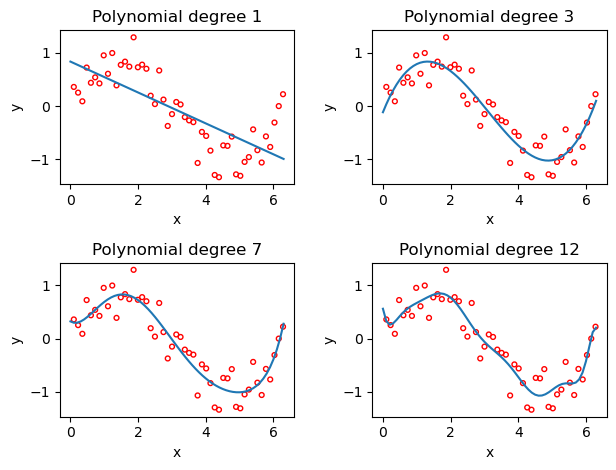

In [14]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [15]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # split the data based on the given ratio
    # ***************************************************
    indices = np.random.permutation(y.shape[0])
    tr_size = np.floor(y.shape[0] * ratio).astype(int)
    tr_indices, te_indices = indices[:tr_size], indices[tr_size:]
    x_tr, y_tr = x[tr_indices], y[tr_indices]
    x_te, y_te = x[te_indices], y[te_indices]
    
    return x_tr, x_te, y_tr, y_te

In [16]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [17]:
from costs import *
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)

    # ***************************************************
    # form train and test data with polynomial basis function
    # ***************************************************
    x_tr_poly, x_te_poly = bp.build_poly(x_tr, degree), bp.build_poly(x_te, degree)

    # ***************************************************
    # calculate weight through least square
    # ***************************************************
    weights, mse_tr = least_squares(y_tr, x_tr_poly)
    rmse_tr = np.sqrt(2 * mse_tr)

    # ***************************************************
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    # ***************************************************
    mse_te = compute_loss(y_te, x_te_poly, weights)
    rmse_te = np.sqrt(2 * mse_te)

    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=rmse_tr, te=rmse_te
        )
    )

    return x_tr, x_te, y_tr, y_te, weights

Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.352
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.308
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.333
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.328
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proport

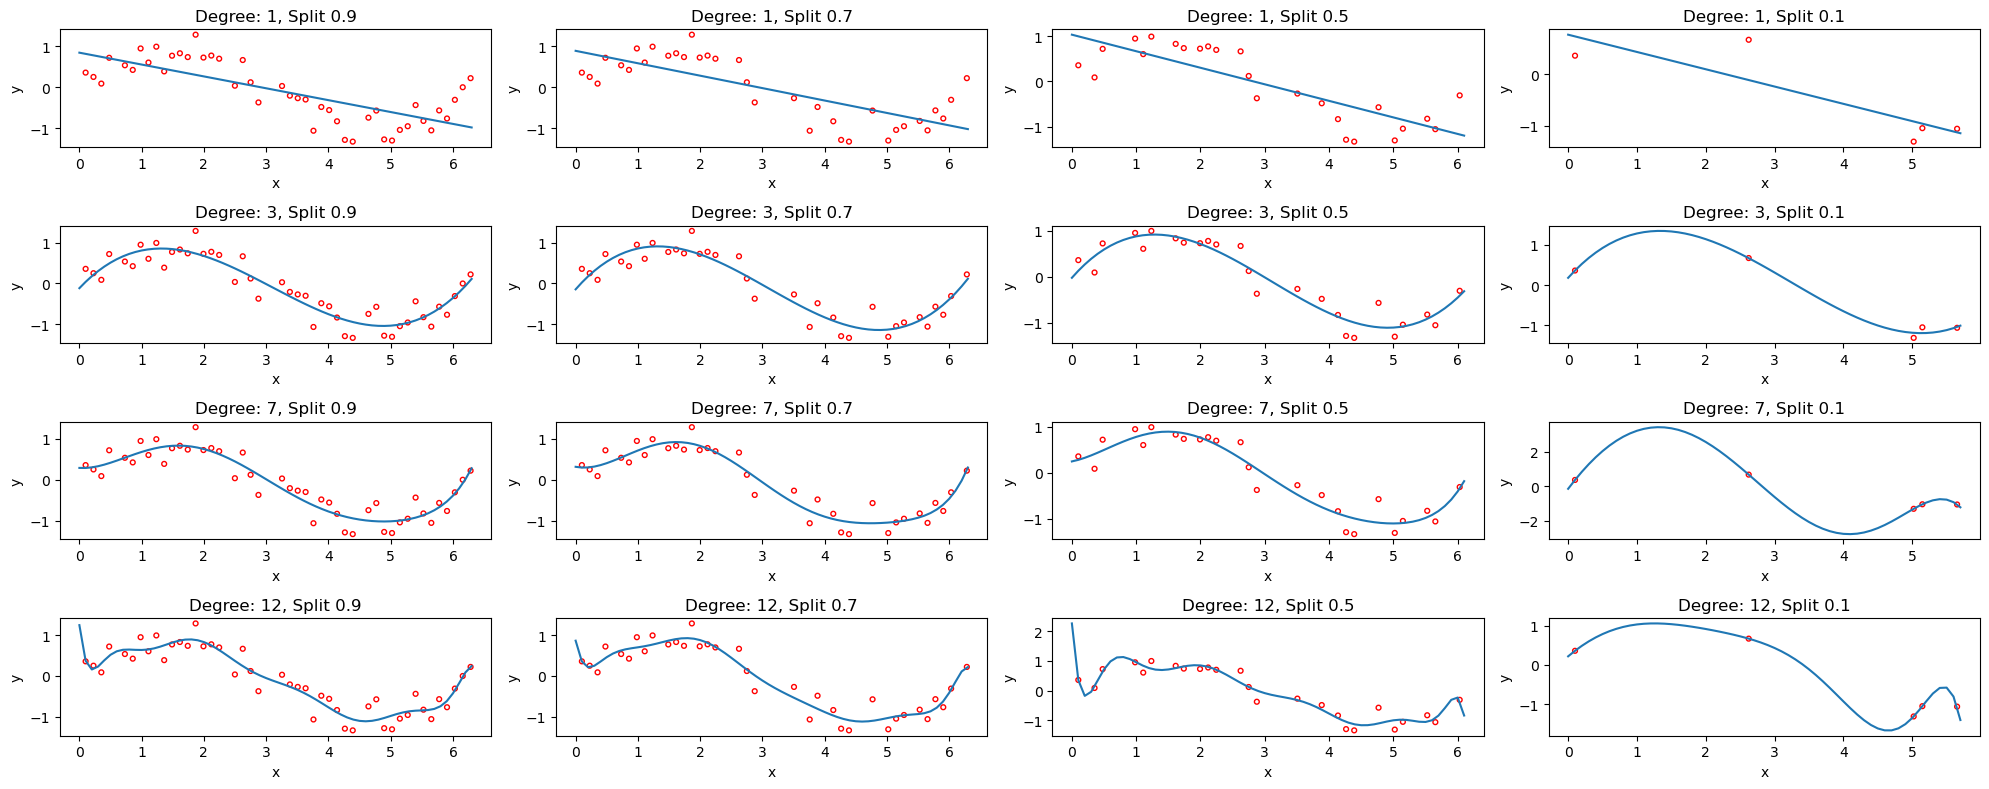

In [18]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [19]:
def norm_2(v):
    return (v ** 2).sum()

def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    N, D = tx.shape
    I = np.identity(D)
    # lambda' = 2N * lamba
    optimal_weights = np.linalg.solve(tx.T @ tx + 2 * N * lambda_ * I, tx.T @ y)
    
    return optimal_weights

In [20]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [21]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)

    # ***************************************************
    # form train and test data with polynomial basis function
    # ***************************************************
    x_tr_poly = bp.build_poly(x_tr, degree)
    x_te_poly = bp.build_poly(x_te, degree)


    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # ridge regression with a given lambda
        # ***************************************************
        weights = ridge_regression(y_tr, x_tr_poly, lambda_)

        mse_tr = compute_loss(y_tr, x_tr_poly, weights)
        rmse_tr.append(np.sqrt(2 * mse_tr))

        mse_te = compute_loss(y_te, x_te_poly, weights)
        rmse_te.append(np.sqrt(2 * mse_te))

        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]
            )
        )
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

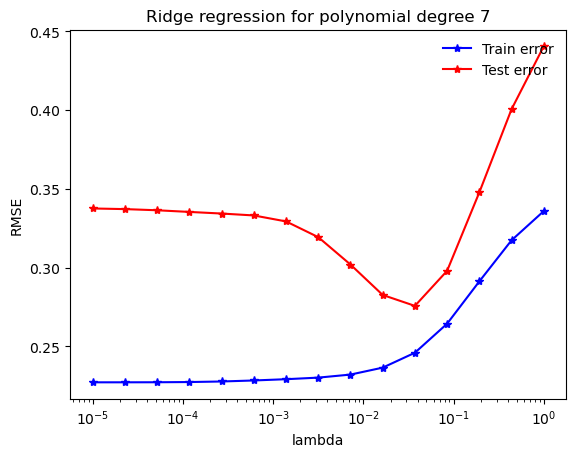

In [22]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)

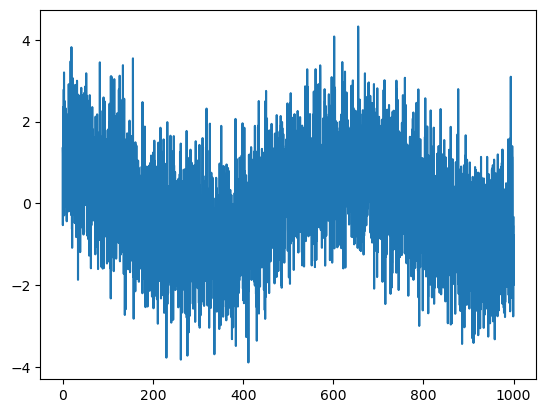

In [33]:
x = np.linspace(0, 1000, 5000)
y = np.cos(0.01 * x)

noise = np.random.normal(0, 1, y.shape)
y = y + noise

plt.plot(x, y)

proportion=0.9, degree=1, Training RMSE=1.194, Testing RMSE=1.229
proportion=0.9, degree=3, Training RMSE=1.054, Testing RMSE=1.092
proportion=0.9, degree=7, Training RMSE=0.981, Testing RMSE=1.007
proportion=0.9, degree=12, Training RMSE=0.981, Testing RMSE=1.007
proportion=0.7, degree=1, Training RMSE=1.192, Testing RMSE=1.210
proportion=0.7, degree=3, Training RMSE=1.053, Testing RMSE=1.069
proportion=0.7, degree=7, Training RMSE=0.982, Testing RMSE=0.991
proportion=0.7, degree=12, Training RMSE=0.981, Testing RMSE=0.990
proportion=0.5, degree=1, Training RMSE=1.172, Testing RMSE=1.223
proportion=0.5, degree=3, Training RMSE=1.039, Testing RMSE=1.077
proportion=0.5, degree=7, Training RMSE=0.974, Testing RMSE=0.997
proportion=0.5, degree=12, Training RMSE=0.973, Testing RMSE=0.997
proportion=0.1, degree=1, Training RMSE=1.161, Testing RMSE=1.206
proportion=0.1, degree=3, Training RMSE=1.004, Testing RMSE=1.066
proportion=0.1, degree=7, Training RMSE=0.947, Testing RMSE=0.994
proport

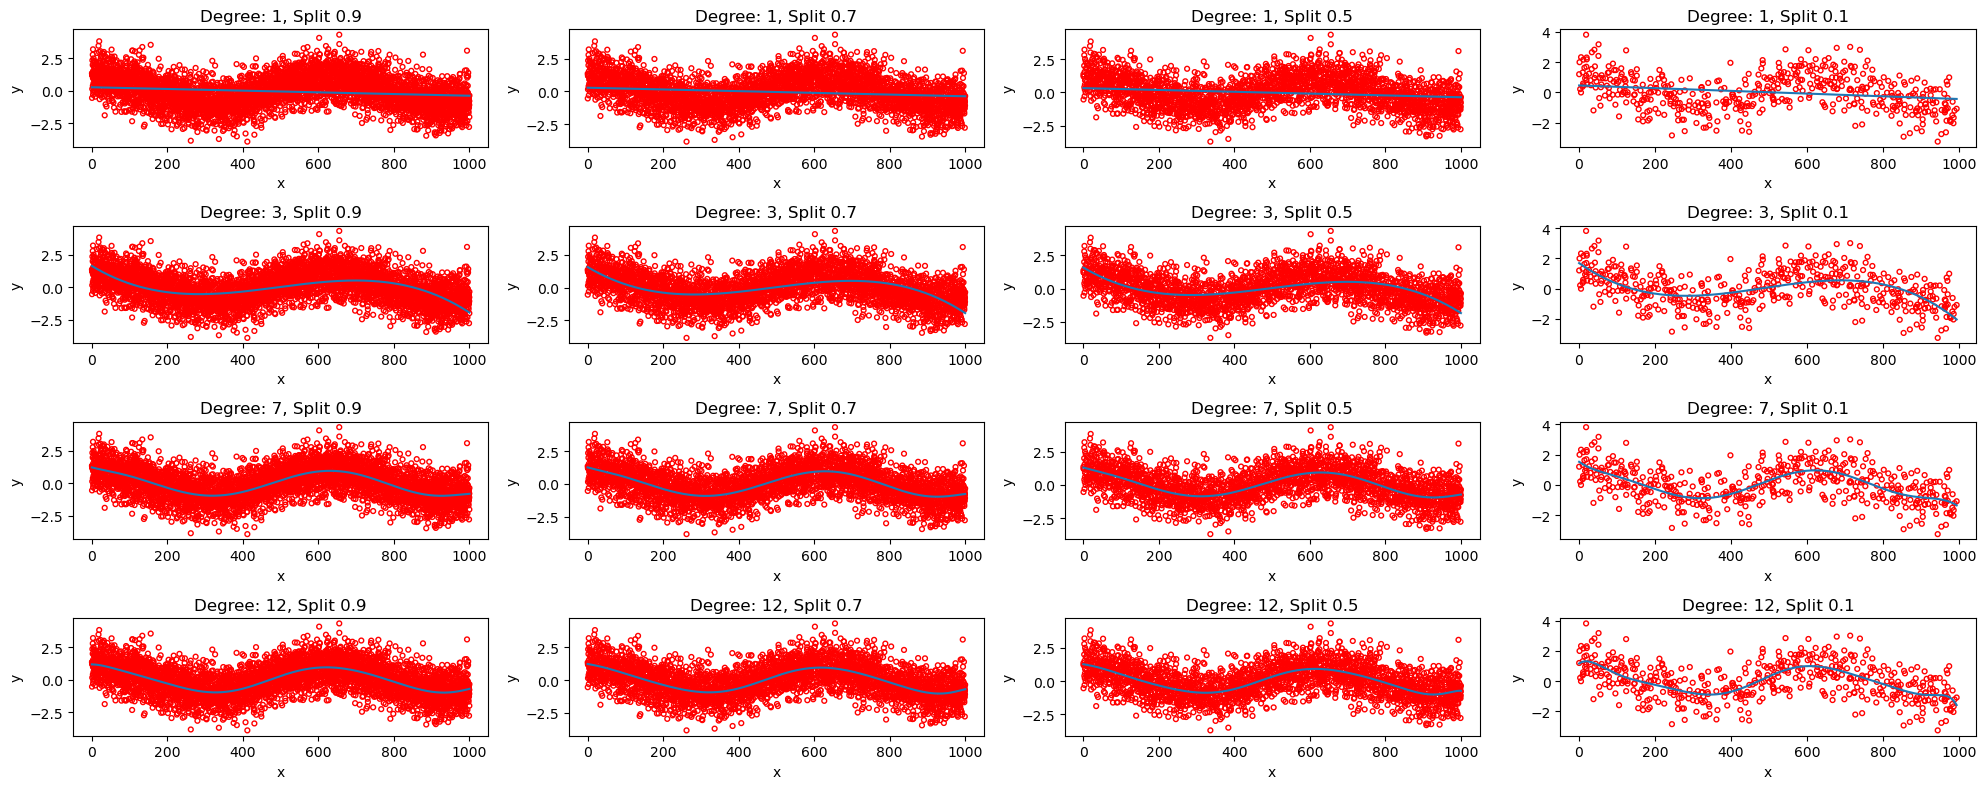

In [34]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()